# Importations et chargement des donéees 

In [1]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
from joblib import dump, load
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from preprocessing_functions import encode_labels, encode_onehot, engineer_features, less_filled, drop_outliers_all, preprocess_data, load_joblibs
from sklearn.linear_model import LinearRegression



In [2]:
# data_dir: Répertoire contenant les bases de données
data_dir = 'home-credit-default-risk'
# app: Table contenant les données de chaque candidature
app = pd.read_csv(data_dir + '/application_train.csv')
# bureau: Table des données des prêt effectués dans des organismes extérieures
bureau = pd.read_csv(data_dir + '/bureau.csv')
prev_app = pd.read_csv(data_dir + '/previous_application.csv')
card = pd.read_csv(data_dir+'/credit_card_balance.csv')
cash = pd.read_csv(data_dir+'/POS_CASH_balance.csv')


On enregistre la variable target et les indentifiants des clients dans des séries à part.

In [3]:
# target: Valeurs à prédire
target = app['TARGET']
target.index = app['SK_ID_CURR']
app.drop(columns=['TARGET'], inplace=True)

In [4]:
# client_id: Series contenant les identifiants des clients
client_id = app.index

# Feature engineering

Une variable qu'on suppose déterminante, est la somme des paiements annuels liés aux prêts pour chaque client. On va extraire les informations des prêts actifs.

## previous_application: Annuity

Essayons de compléter les valeurs manquantes de cette variable

In [5]:
prev_app_corr = prev_app.corr()
prev_app_corr['AMT_ANNUITY'].sort_values(ascending=False).head()

AMT_ANNUITY        1.000000
AMT_GOODS_PRICE    0.820895
AMT_CREDIT         0.816429
AMT_APPLICATION    0.808872
CNT_PAYMENT        0.394535
Name: AMT_ANNUITY, dtype: float64

In [6]:
print("Taux de remplissage: %.2f" % (prev_app.count()['AMT_CREDIT']/len(prev_app)))

Taux de remplissage: 1.00


## Fonction de feature engineering

Le feature engineering est concentré dans une fonction définie dans le fichier preprocessing_functions.py.   
Cette fonction va agréger l'ensemble des données contenues dans les tables POS_CASH_balance, credit_balance, previous_application, bureau. Elle va aussi créer de nouvelles variables, notamment des indicateurs liés au crédit actuellement actifs.

In [7]:
app = engineer_features(app, bureau, prev_app, card, cash)

On **enregistre les identifiants des clients à part**, car ce n'est pas une variable qu'on veut prendre en compte pour la prédiction.

# Encodage

On  va encoder les variables catégorielles pour avoir des profils représentés par des **variables quantitatives uniquement**.

## Ciblage des variables catégorielles

Cibler les variables catégorielles va permettre de:
- Encoder celles qui sont à valeurs dans object
- Faire une imputation et un ré-échantillonnage adapter au type de variable.

In [8]:
# rexexp: Pré-fixes des variables catégorielles à valeurs entières dans application
regexp = '(FLAG_)|(REG_)|(LIVE_)'
# quali_int: Variables catégorielles à valeurs entières
quali_int = app.select_dtypes(include=["int"]).columns
quali_int = quali_int[[bool(re.match(regexp, feature)) for feature in quali_int]]
# quali_obj: Variables catégorielles à valeurs dans object
quali_obj = app.select_dtypes(include=["object"]).columns.tolist()


Reste à différencier les cas d'encodage en fonction de si la variable:
- A uniquement 2 valeurs possibles: **LabelEncoder**
- Ou si elle en a plus de 2: **OneHotEncoder**

In [9]:
# n_uniq_obj: Nombre de valeurs pour une variable catégorielle (ici, pour les variables à encoder)
n_uniq_obj = app[quali_obj].nunique()
# obj_2_uniq: Noms des variables catégorielles à 2 valeurs
obj_2_uniq = n_uniq_obj[n_uniq_obj == 2].index.to_series()
# obj_n_uniq: Noms des variables catégorielles à plus de 2 valeurs
obj_n_uniq = n_uniq_obj[n_uniq_obj > 2].index.to_series()


## Encodage par label

In [10]:
# label_enc: Dictionnaire des encodeurs pour les variables catégorielles de type object à 2 valeurs 
label_enc = {}
for feature in obj_2_uniq.index:
    label_enc[feature], app[feature] = encode_labels(feature, app)

## Encodage OneHot

In [11]:
# onehot_enc: Encodeur onehot de notre table principale
onehot_enc, app = encode_onehot(obj_n_uniq, app)

In [12]:
# names_quali: On enregistre la liste des variables catégorielles
names_quali = quali_int.tolist()+onehot_enc.get_feature_names_out().tolist()+obj_2_uniq.tolist()


On supprime certaines variables correspondant à la valeur NaN contenue dans une variable catégorielle.

In [13]:
regexp1, regexp2 = "XNA", 'nan'
# is_nan: Contient si la variable représente la présence de la valeur NaN
is_nan = np.array([bool(re.search(regexp1, col)) or bool(re.search(regexp2, col)) for col in app.columns])
# cols_nan: Colonnes représentant la valeur NaN dans une variable
cols_nan = app.columns[is_nan]

In [14]:
app.drop(columns=cols_nan, inplace=True)
# On met à jour la liste de nos variables catégorielles
names_quali = [feature for feature in names_quali if feature not in cols_nan]

# Nettoyage   
Pour le nettoyage, on va:
- Supprimer les **doublons**
- Supprimer les **variables redondantes**, en se basant sur les corrélations fortes
- Supprimer les **variables faiblement corrélées** à la target
- Supprimer les **colonnes creuses**
- Supprimer les **outliers**
- **Imputer** les données manquantes:
    - **Par la moyenne** pour les variables quantitatives
    - **Par la valeur la plus fréquente** pour les catégories
- **Réduire et normaliser** les données

## Étude des corrélations

### Calcul des coefficients de corrélation

In [15]:
# corr_matrix: Tableau des coefficients de corrélation pour chaque couple de variables
app['TARGET'] = target
# corr_matrix: Matrice des corrélations de notre table
corr_matrix = app.corr()
app.drop(columns=['TARGET'], inplace=True)


On va construire la tables des paires de corrélations, contenant 3 colonnes:
- **feature_1**: Nom de la 1ère feature
- **feature_2**: Nom de la 2ème feature
- **pearson**: Coefficient de corrélation entre feature_1 et feature_2

In [16]:
# corr_data: Matrice des corrélation avec NaN à la place des doublons
corr_data = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# corr_data: Liste contenant les triplet (feature1, feature2, coefficient_corr)
corr_data = corr_data.unstack().reset_index()
corr_data.columns = ['feature_1', 'feature_2', 'pearson']
# On supprime les coefficients valant NaN (qui étaient des doublons)
corr_data.dropna(subset=['pearson'], inplace=True)
# On prend la valeur absolue arrondie à 3 chiffres des coefficients
corr_data['pearson'] = round(corr_data['pearson'], 3)
corr_data['pearson'] = abs(corr_data['pearson'])
corr_data = corr_data.sort_values(by='pearson', ascending=False)


### Suppression des corrélations fortes

In [17]:
# corr_min: Coefficient minimal pour considérer la corrélation comme forte
corr_min = 0.75
# corr_data: Va contenir les paire de variables fortement corrélées
corr_data = corr_data[corr_data['pearson'] >= corr_min]
print("On a trouvé %d corrélations fortes" % len(corr_data))


On a trouvé 584 corrélations fortes


Pour chaque couple de variables corrélées fortement, on prend **la variable dont le taux de remplissage est le plus élevé**.

In [18]:
# corr_features: Va contenir la liste des variables à supprimer, car redondantes
corr_features = corr_data[['feature_1', 'feature_2']]
corr_features = corr_features.apply(less_filled, args=(corr_matrix['TARGET'].map(abs),), axis=1)


### Suppression des corrélations faibles

In [19]:
# corr_target: Série contenant les corrélations des features avec la target
corr_target = corr_matrix['TARGET']
# least_corr_features: Variables peu pertinentes, car faiblement corrélée avec la target
least_corr_features = corr_target.index[abs(corr_target) < 0.05]

In [20]:
print("%d variables suffisamment corrélées à TARGET" % (len(app.columns)-len(least_corr_features)))

76 variables suffisamment corrélées à TARGET


Les variables les plus corrélées à la cible sont:

In [51]:
abs(corr_target.dropna()).sort_values(ascending=False).iloc[1:10]

EXT_SOURCE_3                                    0.178919
EXT_SOURCE_2                                    0.160472
EXT_SOURCE_1                                    0.155317
bureau_DAYS_CREDIT_mean                         0.091525
bureau_CREDIT_ACTIVE_Closed_count_norm          0.081102
bureau_CREDIT_ACTIVE_Active_count_norm          0.079090
DAYS_BIRTH                                      0.078239
bureau_DAYS_CREDIT_min                          0.078046
prev_NAME_CONTRACT_STATUS_Refused_count_norm    0.077671
Name: TARGET, dtype: float64

### Mise à jour
On va maintenant prendre en compte les résulats de l'étude des corrélations dans notre étude.

In [22]:
# to_drop: Variables à supprimer, suite à l'étude des corrélations
to_drop = set(corr_features.tolist()+least_corr_features.tolist())

On va obligatoirement garder certaines variables indispensables:
- La rente annuelle
- Les revenus annuels
- Le montant total du crédit

In [24]:
for feature_to_keep in ['AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']:
    if feature_to_keep in to_drop:
        to_drop.remove(feature_to_keep)

In [25]:
print("%d variables suffisamment corrélées à TARGET et pas fortement corrélées à d'autres" % (len(app.columns)-len(to_drop)))

71 variables suffisamment corrélées à TARGET et pas fortement corrélées à d'autres


On met à jour la liste des variables catégorielles de notre table.

In [26]:
# On supprime ces variables de notre table
app.drop(columns=to_drop, inplace=True)

In [27]:
# names_quali: Content les noms des variables catégorielles de notre table
names_quali = [feature for feature in names_quali if feature not in to_drop]


## Colonnes creuses
On va supprimer les colonnes trop faiblement remplies.

In [28]:
# ratio_filled: Taux de remplissage des colonnes
ratio_filled = app.count()/len(app)
# min_ratio: Taux de remplissage minimal exigé pour imputer une varible
min_ratio = 0.75
# to_drop: Colonnes creuses à supprimer
to_drop = app.columns[ratio_filled<min_ratio]
app.drop(columns=to_drop, inplace=True)

In [29]:
# names_quali: On met à jour la liste des variables catégorielles
names_quali = [feature for feature in names_quali if feature not in to_drop]

## Outliers
On va simplement supprimer les individus présentant des valeurs excessives pour des variables.

In [30]:
# names_quanti: Noms des features quantitatives
names_quanti = app.columns[~app.columns.isin(pd.Index(names_quali))]

On va prendre une marge de 5x l'écart interquartile.

In [31]:
drop_outliers_all(app, names_quanti, n_iqr=5)

## Imputation

### Imputation par la moyenne

Pour les variables quantitatives, on utilise une simple **imputation par la moyenne**.

In [32]:
# mean_imputer: Imputeur par la moyenne
mean_imputer = SimpleImputer(strategy='mean')
mean_imputer.fit(app[names_quanti])
# On impute les variables quantitatives
app.loc[:, names_quanti] = mean_imputer.transform(app[names_quanti])


### Imputation par la valeur la plus fréquente

Pour les variables catégorielles, on utilise **impute avec la valeur la plus fréquente**.

In [33]:
# freq_imputer: Imputeur par la valeur la plus fréquence
freq_imputer = SimpleImputer(strategy='most_frequent')
freq_imputer.fit(app[names_quali])
# On impute les variables qualitatives
app.loc[:, names_quali] = freq_imputer.transform(app[names_quali])


## Normalisation des données

In [34]:
# std_scaler: Normaliseur standard
std_scaler = StandardScaler()
# application_scaled:
application_scaled = std_scaler.fit_transform(app)


## Bilan

In [35]:
print("Finalement, on a une table d'entraînement de %d individus et %d variables" % (len(app), len(app.columns)))

Finalement, on a une table d'entraînement de 20416 individus et 39 variables


# Exportation

## Sauvegarde des opérateurs du pré-traitement 

On enregistre les encodeurs, les imputeurs et le normaliseur dans des fichiers joblib.

In [36]:
# job_dir: Répertoire dans lequel enregistrer les fichier joblib
job_dir = './joblib'
dump(onehot_enc, job_dir+'/onehot_enc.joblib')
dump(mean_imputer, job_dir+'/mean_imputer.joblib')
dump(freq_imputer, job_dir+'/freq_imputer.joblib')
for feature, encoder in label_enc.items():
    dump(encoder, job_dir+'/label_encoder-'+feature+'.joblib')
dump(std_scaler, job_dir+'/scaler.joblib')


['./joblib/scaler.joblib']

## Essai sur les données de test

In [37]:
# app_test: Données des candidatures de l'échantillon de tes
data_dir = 'home-credit-default-risk'
app_test = pd.read_csv(data_dir + '/application_test.csv')
bureau = pd.read_csv(data_dir + '/bureau.csv')
prev_app = pd.read_csv(data_dir + '/previous_application.csv')
card = pd.read_csv(data_dir+'/credit_card_balance.csv')
cash = pd.read_csv(data_dir+'/POS_CASH_balance.csv')
onehot_enc, label_enc, mean_imputer, freq_imputer, scaler = load_joblibs(
    './joblib')


In [38]:
app_test = preprocess_data(
    app_test, bureau, prev_app, card, cash, onehot_enc, label_enc, mean_imputer, freq_imputer, scaler)


# Visualisation des données

In [39]:
tsne = TSNE(n_components=2, perplexity=50, random_state=0, init='pca', learning_rate='auto')

In [40]:
app['TARGET'] = target
app_samp = app.sample(1000)
target_samp = app_samp['TARGET']
app_samp.drop(columns=['TARGET'], inplace=True)

In [41]:
app_tsne = tsne.fit_transform(app_samp)

/home/ilyes/OC/P7/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


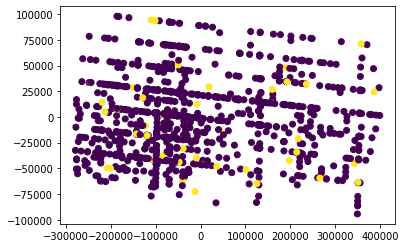

In [42]:
plt.scatter(app_tsne[:, 0], app_tsne[:, 1], c=target_samp)

In [43]:
tsne.kl_divergence_

2.757620096206665